# Pneumonia Detection X-ray

*  Marta Álvarez Fernández
*  Ana Vera Peña
*  Leticia Cólogan Valero


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

The dataset has been obtained from: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download



In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', context='talk', palette='Spectral', font_scale=0.9)

In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/chest_xray'

Mounted at /content/drive


In [ ]:
# Variables con los paths a los directorios de cada conjunto
test_dir = os.path.join(root_path, 'test')
train_dir = os.path.join(root_path, 'train')
val_dir = os.path.join(root_path, 'val')

# Exploratory Analysis

**Proportion of classes in datasets**

The first thing we must check is the distribution of classes in our dataset. This must be sufficiently balanced so that the analysis is meaningful and we don't draw conclusions that are later unrepresentative of the population.


In [ ]:
#Count the number of images belonging to each set.
def count_samples():
  samples = {}
  for set_ in ['test', 'train', 'val']:
    samples[set_] = {}
    for class_ in ['NORMAL', 'PNEUMONIA']:
      path = os.path.join(root_path, set_)
      k = len(os.listdir(f'{path}/{class_}'))
      samples[set_].update({class_: k})

  df_samples = pd.DataFrame(samples)
  return df_samples

df_samples = count_samples()

# Total number of observations
n = df_samples.values.sum()
# Number of positive and negative cases
n_neg, n_pos = df_samples.sum(axis = 1).values

print(f'Num. de casos positivos: {n_pos} = {n_pos / n:.2f} %')
print(f'Num. de casos negativos: {n_neg} = {n_neg / n:.2f} %')

Num. de casos positivos: 4273 = 0.73 %
Num. de casos negativos: 1583 = 0.27 %


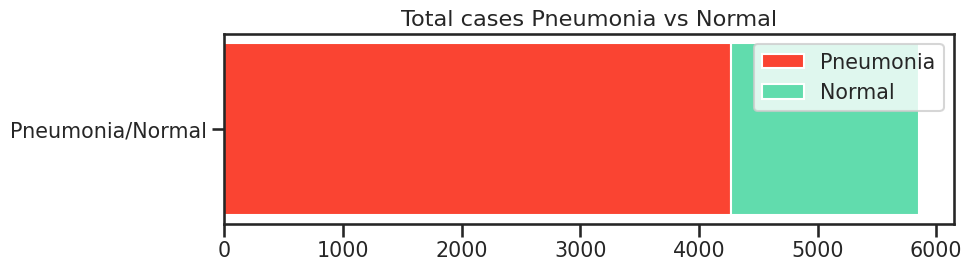

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))


ax.barh(['Pneumonia/Normal'], [n_pos], color='#fa4432', label='Pneumonia')
ax.barh(['Pneumonia/Normal'], [n_neg], left=[n_pos], color='#61dcad', label='Normal')

ax.set_title('Total cases Pneumonia vs Normal')
ax.legend()
plt.tight_layout()
plt.show()


Clearly, there are a majority of pneumonia cases, which makes us think this is a very good sign, as it will allow us to build models that learn different image characteristics, which will speed up detection and facilitate the work of doctors. However, we need to balance the dataset to obtain good results.

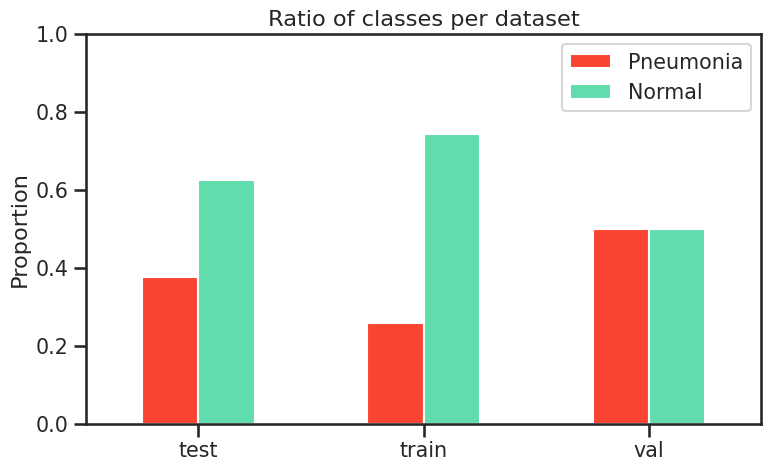

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))


proporciones = df_samples.div(df_samples.sum(axis=0), axis=1).T


proporciones.plot(
    kind='bar',
    ax=ax,
    color=['#fa4432', '#61dcad'],
    rot=0
)

ax.set_ylim(0, 1)
ax.set_ylabel('Proportion')
ax.set_title('Ratio of classes per dataset')
ax.legend(['Pneumonia', 'Normal'], loc='upper right')

plt.tight_layout()
plt.show()

It seems that the class balance varies significantly depending on the dataset split. In the training and test sets, normal cases outnumber patients with pneumonia. This difference is especially noticeable in the training set. In contrast, the validation set contains an equal proportion of images from both classes.

**Visualization**

It's essential to understand our dataset and the images we'll later classify. To do this, we'll randomly obtain images for each class in each set.

In [ ]:
import tensorflow.keras as k
from tensorflow.keras.preprocessing.image import load_img, img_to_array

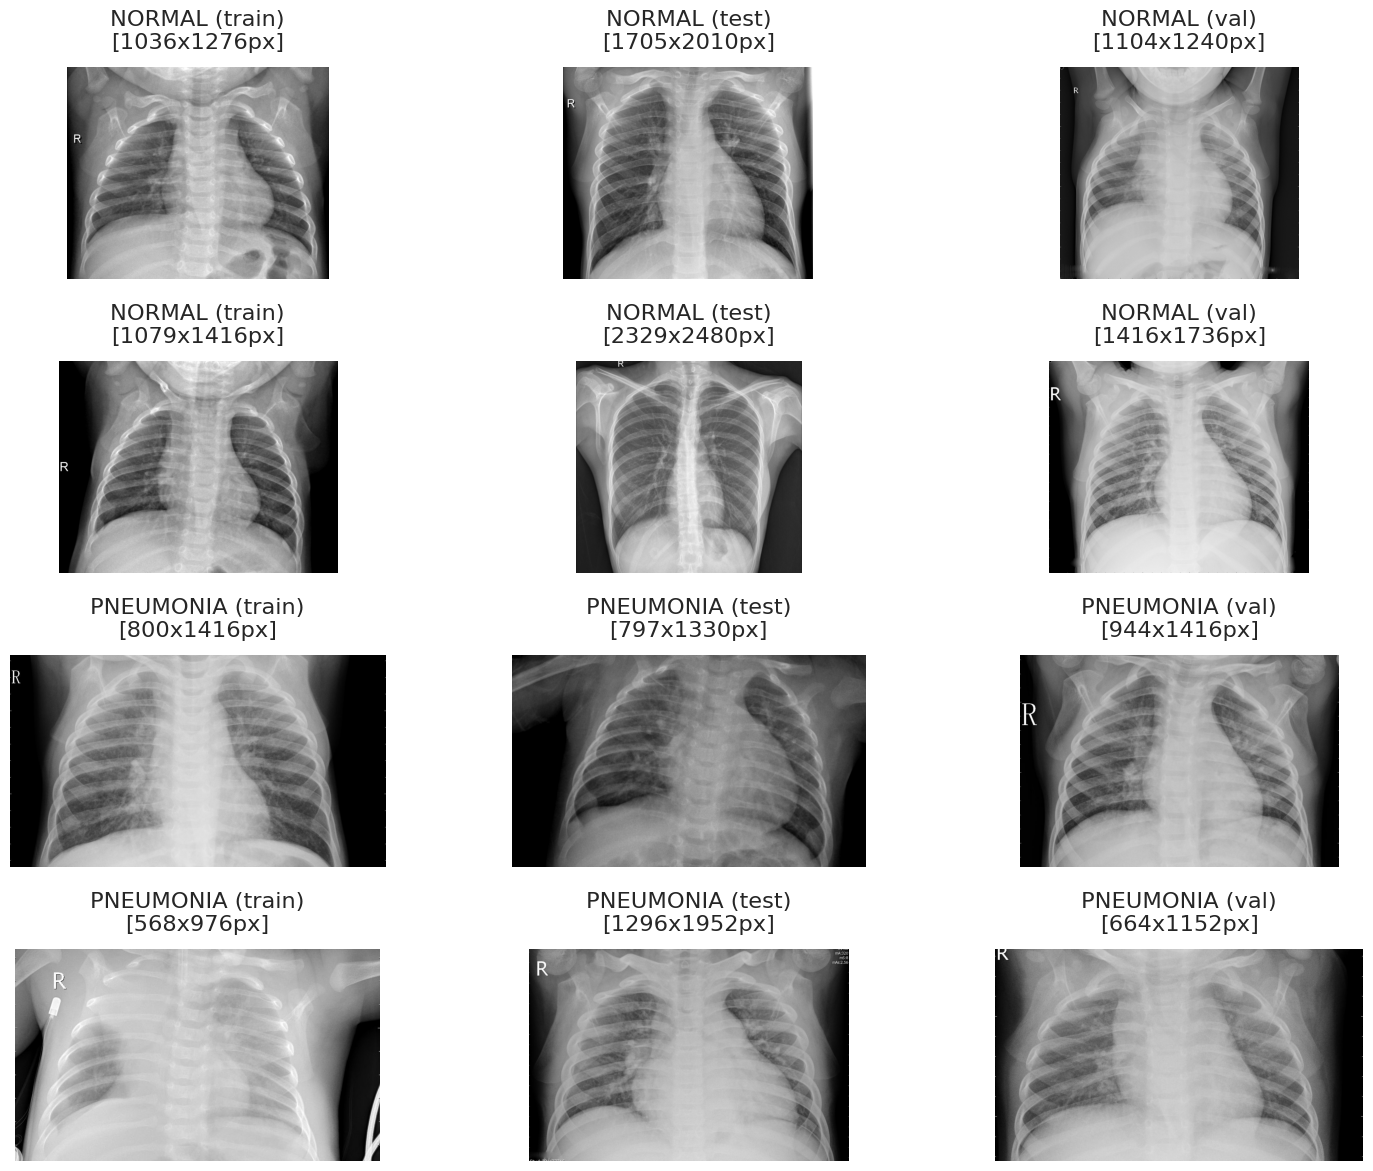

In [ ]:
def show_random_images():
    fig, ax = plt.subplots(4, 3, figsize=(15, 12))  # 4 filas (2 por clase), 3 columnas (train, test, val)
    clases = ['NORMAL', 'PNEUMONIA']
    conjuntos = ['train', 'test', 'val']

    for i, clase in enumerate(clases):
        for j, conjunto in enumerate(conjuntos):
            ruta = os.path.join(root_path, conjunto, clase)
            archivos = os.listdir(ruta)
            seleccionadas = np.random.choice(archivos, size=2, replace=False)

            for k in range(2):
                fila = i * 2 + k  # 0,1 para NORMAL / 2,3 para PNEUMONIA
                img_path = os.path.join(ruta, seleccionadas[k])
                img = load_img(img_path)
                ancho, alto, _ = img_to_array(img).shape
                ax[fila, j].imshow(img)
                ax[fila, j].set_title(f'{clase} ({conjunto})\n[{ancho}x{alto}px]', y=1.05)
                ax[fila, j].axis('off')
                borde_color = '#fa4432' if clase == 'PNEUMONIA' else '#61dcad'
                ax[fila, j].patch.set_edgecolor(borde_color)
                ax[fila, j].patch.set_linewidth(8)

    plt.tight_layout()
    plt.show()

show_random_images()

The first thing to note is the inequality in sizes; this is essential to keep in mind when building subsequent models.

Let's focus on the training set. For this, we'll perform a detailed analysis by loading a sample of 200 images at random.

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def load_random_images(ruta, tamaño=(150, 150), cantidad=200):
    "Loads a random sample of grayscale images from a specified folder and converts them to a NumPy array."

    archivos = np.random.choice(os.listdir(ruta), size=cantidad, replace=False)
    imagenes = []

    for archivo in archivos:
        img = load_img(
            os.path.join(ruta, archivo),
            target_size=tamaño,
            color_mode='grayscale'
        )
        arr = img_to_array(img)
        imagenes.append(arr)

    return np.stack(imagenes, axis=0)



ANCHO, ALTO = 150, 150
categorias = ['NORMAL', 'PNEUMONIA']
training_images = {}

# Solo trabajamos con el conjunto de entrenamiento
for categoria in categorias:
    ruta_categoria = os.path.join(root_path, 'train', categoria)
    imagenes = load_random_images(ruta_categoria, tamaño=(ANCHO, ALTO))
    training_images[categoria] = imagenes

# Verificamos las claves cargadas
print(training_images.keys())

dict_keys(['NORMAL', 'PNEUMONIA'])


## Stadistics

In [ ]:
datos = training_images['PNEUMONIA']

print('Forma del tensor:', datos.shape)
print('Rango de valores: [%.1f, %.1f]' % (datos.min(), datos.max()))
print('Promedio global: %.2f' % datos.mean())
print('Desviación estándar: %.2f' % datos.std())

Forma del tensor: (200, 150, 150, 1)
Rango de valores: [0.0, 255.0]
Promedio global: 124.17
Desviación estándar: 59.59


In [ ]:
# Supongamos que tienes un array de imágenes: (n_imágenes, altura, ancho, 1)
datos1 = training_images['NORMAL']

# Estadísticas globales
print('Forma del tensor:', datos1.shape)
print('Rango de valores: [%.1f, %.1f]' % (datos1.min(), datos1.max()))
print('Promedio global: %.2f' % datos1.mean())
print('Desviación estándar: %.2f' % datos1.std())

Forma del tensor: (200, 150, 150, 1)
Rango de valores: [0.0, 255.0]
Promedio global: 122.38
Desviación estándar: 63.20


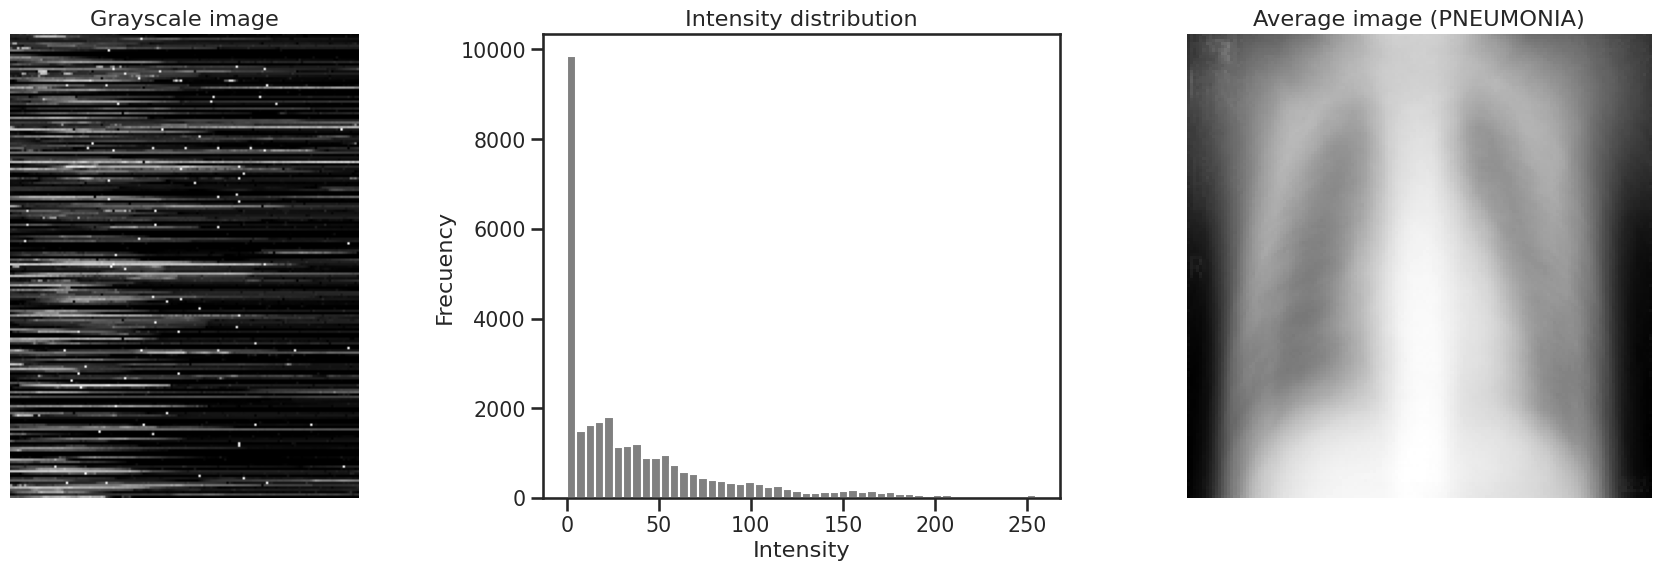

In [ ]:
#Select an image from the training set and class PNEUMONIA
imagen_gris = training_images['PNEUMONIA'][:, :, 0]

plt.figure(figsize=(18, 6))

# Original image
plt.subplot(131)
plt.imshow(imagen_gris, cmap='gray')
plt.title('Grayscale image')
plt.axis('off')

# Histogram
plt.subplot(132)
plt.hist(imagen_gris.ravel(), bins=50, color='gray')
plt.title('Intensity distribution')
plt.xlabel('Intensity')
plt.ylabel('Frecuency')

# Average image
imagen_promedio = np.mean(training_images['PNEUMONIA'], axis=0)  # Cambiar axis=0 para promediar todas las imágenes
plt.subplot(133)
plt.imshow(imagen_promedio, cmap='gray')
plt.title('Average image (PNEUMONIA)')
plt.axis('off')

plt.tight_layout()
plt.show()


This figure underscores the need to remove striping artifacts and denoise chest X-rays, mask background pixels and normalize low‐intensity lung fields, and apply standardized filtering so that averaged pneumonia opacities stand out—ensuring a model learns pathology rather than noise.

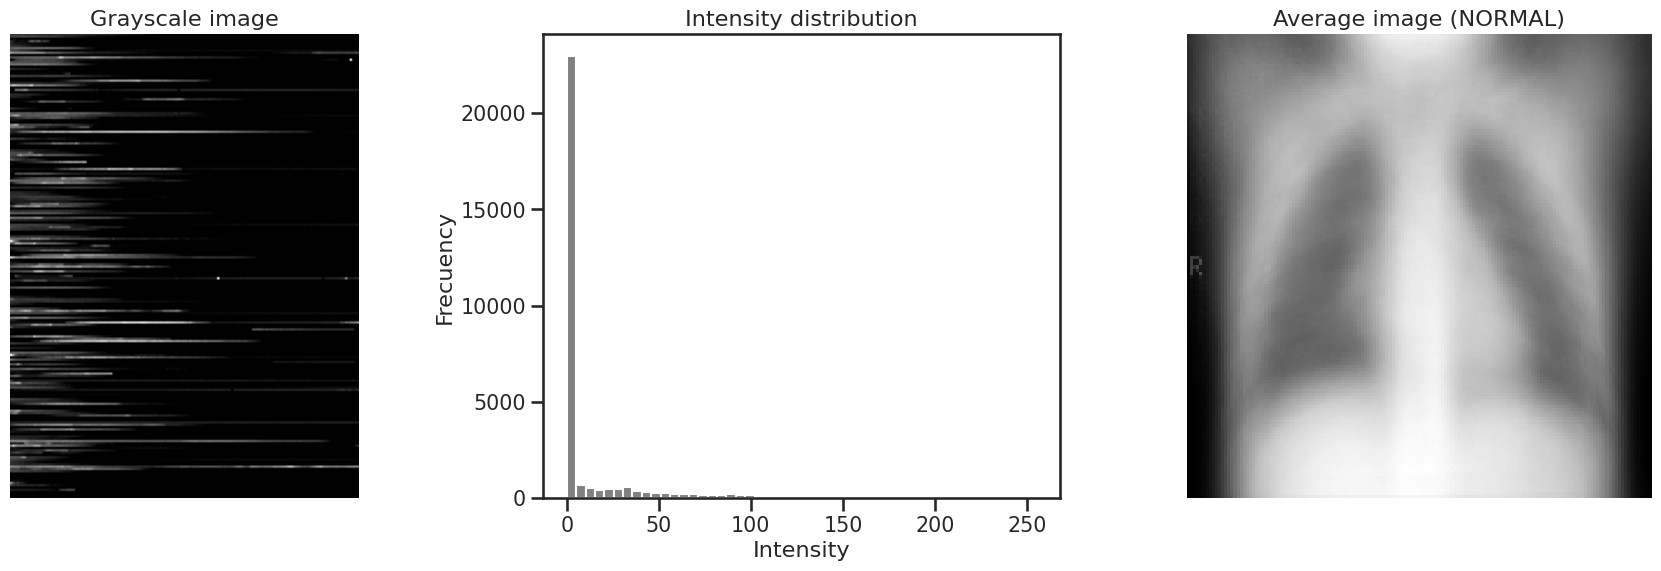

In [ ]:
#Select an image from the training set and class NORMAL
imagen_gris = training_images['NORMAL'][:, :, 0]

plt.figure(figsize=(18, 6))

# Original image
plt.subplot(131)
plt.imshow(imagen_gris, cmap='gray')
plt.title('Grayscale image')
plt.axis('off')

# Histogram
plt.subplot(132)
plt.hist(imagen_gris.ravel(), bins=50, color='gray')
plt.title('Intensity distribution')
plt.xlabel('Intensity')
plt.ylabel('Frecuency')

# Average image
imagen_promedio = np.mean(training_images['NORMAL'], axis=0)
plt.subplot(133)
plt.imshow(imagen_promedio, cmap='gray')
plt.title('Average image (NORMAL)')
plt.axis('off')

plt.tight_layout()
plt.show()



This figure again reveals horizontal striping and speckle noise that must be filtered out, a histogram dominated by zero‐intensity background calling for lung‐field masking and intensity rescaling, and—once averaged—a crisp normal lung silhouette with clear aerated fields, underscoring the importance of artifact removal and normalization to highlight true anatomy.  

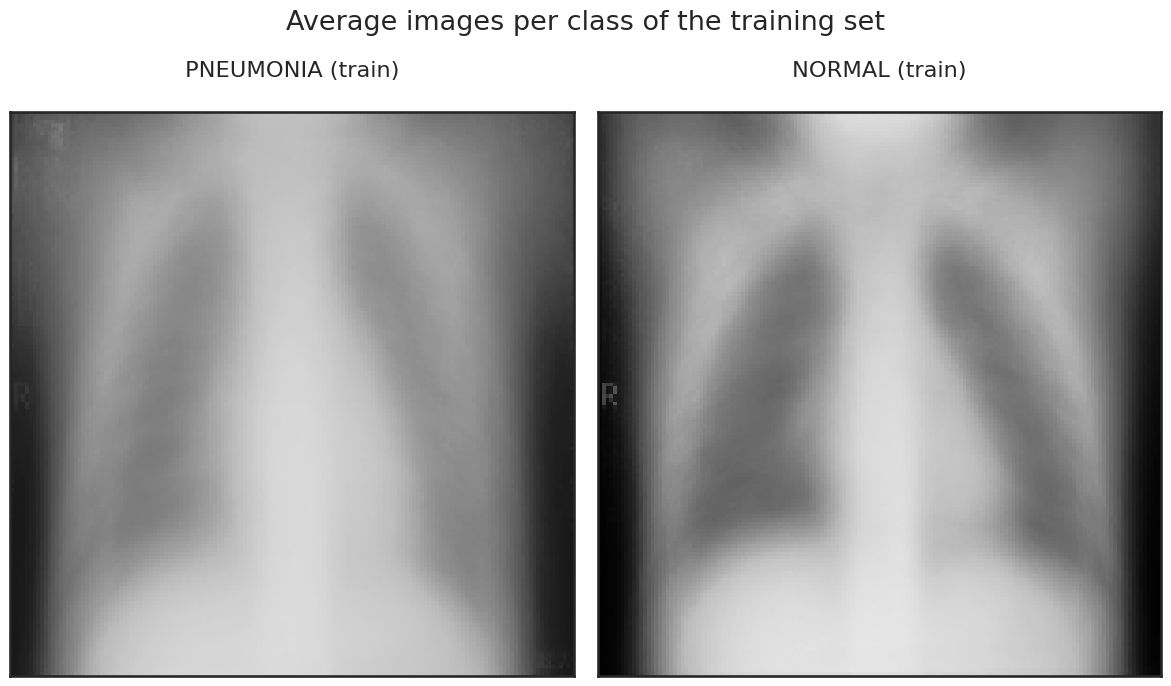

In [ ]:
# Define the classes to be used
categorias = ['PNEUMONIA', 'NORMAL']


fig, ax = plt.subplots(1, 2, figsize=(12, 7))

for j, class_ in enumerate(categorias):

    imgs_tensor = training_images[class_]
    mean_image = np.mean(imgs_tensor, axis=0)


    ax[j].imshow(mean_image.squeeze(), vmin=0, vmax=255, cmap='Greys_r')
    ax[j].set_title(f'{class_} (train)', y=1.05)
    ax[j].set_xticks([])
    ax[j].set_yticks([])

plt.tight_layout()
plt.suptitle("Average images per class of the training set", y=1.05)
plt.show()

**Histogram and FDA**

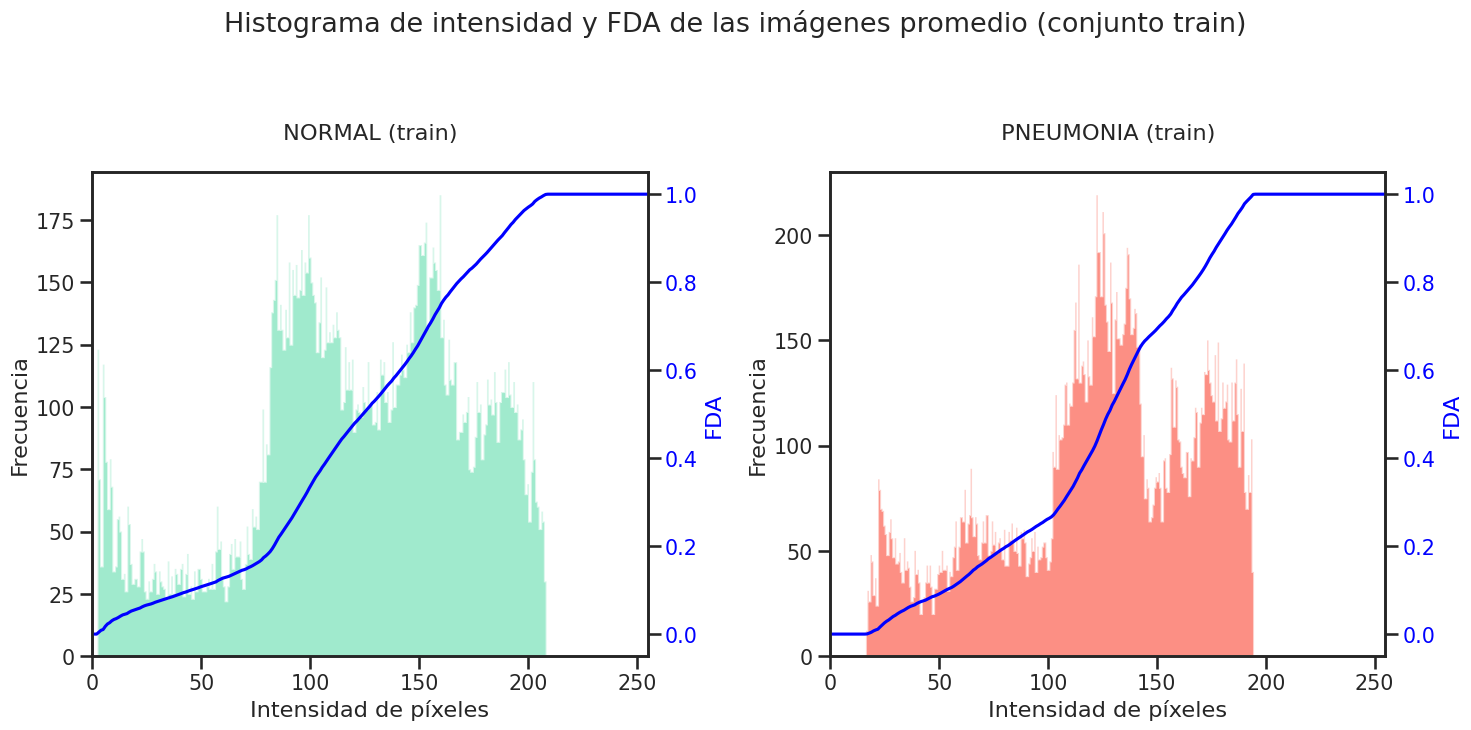

In [ ]:
# Definir las clases y el conjunto
classes = ['NORMAL', 'PNEUMONIA']

# Crear figura para mostrar los resultados
fig, ax = plt.subplots(1, 2, figsize=(15, 7))  # Dos subgráficos, uno para cada clase

for j, class_ in enumerate(classes):
    color = '#fa4432' if class_ == 'PNEUMONIA' else '#61dcad'

    # Obtener las imágenes para la clase actual
    imgs_tensor = training_images[class_]
    mean_image = np.mean(imgs_tensor, axis=0)  # Promediar las imágenes a lo largo del eje de las imágenes

    # Graficar el histograma de la imagen promedio
    ax[j].hist(mean_image.ravel(), bins=256, histtype='stepfilled', color=color, alpha=0.6)

    # Calcular la FDA (Función de Distribución Acumulada)
    hist, bin_edges = np.histogram(mean_image, bins=256, range=(0, 255))
    cdf = hist.cumsum()  # Cálculo de la función de distribución acumulada
    cdf_normalized = cdf / cdf[-1]  # Normalización de la FDA

    # Crear un eje adicional para graficar la FDA
    ax_2 = ax[j].twinx()  # Crear un segundo eje Y
    ax_2.plot(bin_edges[1:], cdf_normalized, color='blue', label='FDA')
    ax_2.set_ylabel('FDA', color='blue')
    ax_2.tick_params(axis='y', labelcolor='blue')  # Ajustar color de los ticks de la FDA

    # Ajustar título y configuraciones de los ejes
    ax[j].set_title(f'{class_} (train)', y=1.05)
    ax[j].set_xlim(0, 255)  # Limitar el rango de intensidad
    ax[j].set_xlabel('Intensidad de píxeles')
    ax[j].set_ylabel('Frecuencia')

plt.suptitle("Histograma de intensidad y FDA de las imágenes promedio (conjunto train)", y=1.05)
plt.tight_layout()
plt.show()



It seems that pixel intensity is reached at different thresholds. On the one hand, it seems that in normal images two peaks are established, one around 100 and the other around 150, whereas in the X-rays of patients with pneumonia the intensity is around 130.

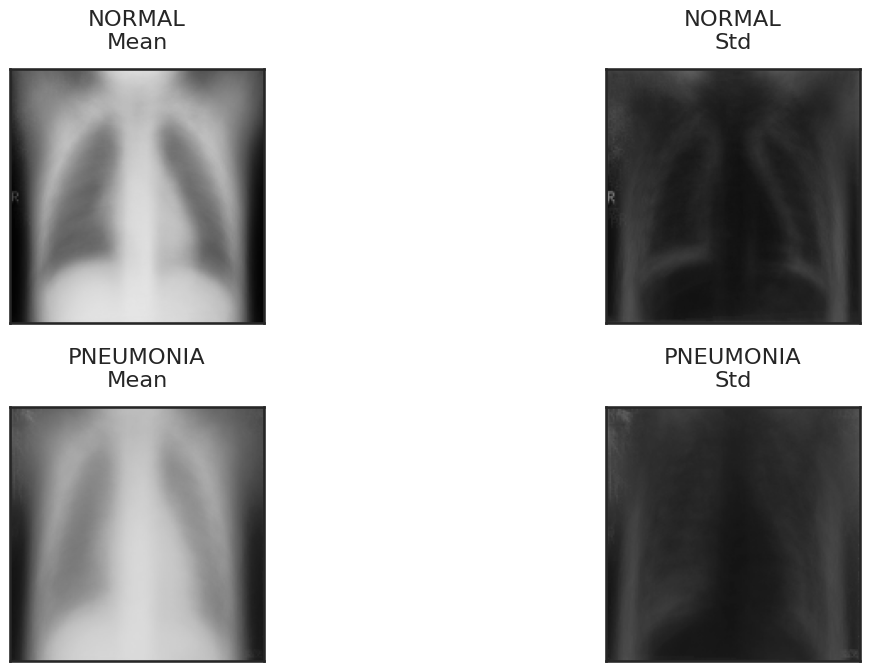

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['NORMAL', 'PNEUMONIA']


fig, ax = plt.subplots(2, 2, figsize=(15, 7))


for j, class_ in enumerate(classes):

    all_imgs = training_images[class_]


    mean_img = np.mean(all_imgs, axis=0)
    std_img = np.std(all_imgs, axis=0)


    img_dic = {'Mean': mean_img, 'Std': std_img}


    for i, (key, img) in enumerate(img_dic.items()):
        ax[j, i].imshow(img, vmin=0, vmax=255, cmap='Greys_r')
        ax[j, i].set_title(f'{class_}\n{key}', y=1.05)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])


plt.tight_layout()
plt.show()


**Brightness Adjustment**

The brightness adjustment is useful to make the model more robust to different lighting conditions. It can be done by adding a constant value to the image pixels or multiplying by a factor.

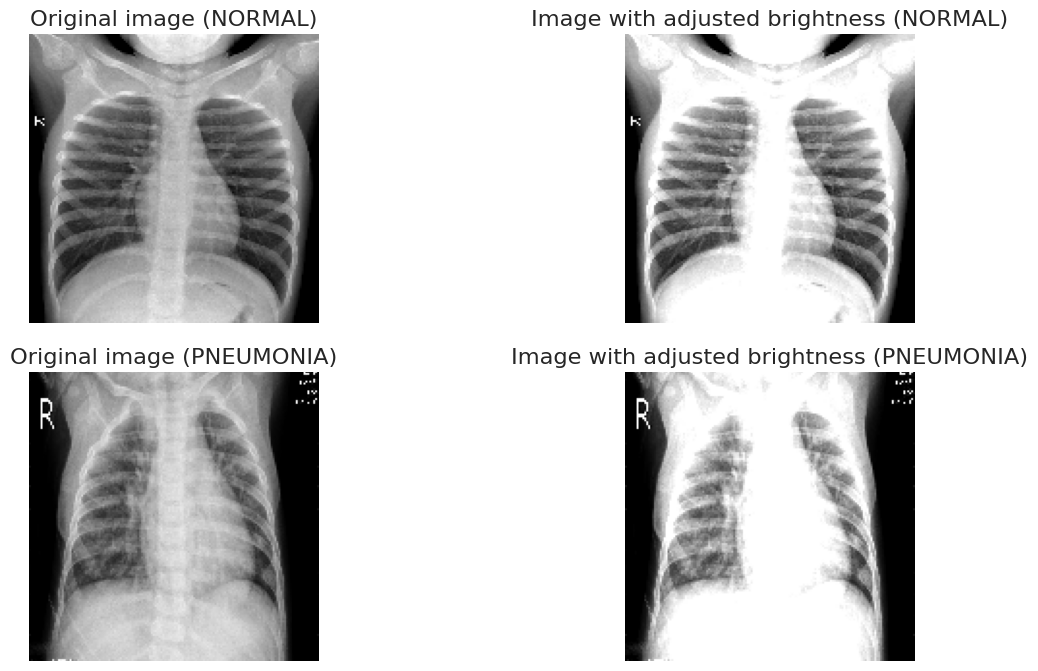

In [ ]:
def adjust_brightness(img, factor=1.5):
    """
    Adjusts the brightness of an image by multiplying all pixels by a factor.
    If factor > 1, the image becomes brighter.
    If factor < 1, the image becomes darker.
    """
    img = img * factor
    img = np.clip(img, 0, 255)
    return img


classes = ['NORMAL', 'PNEUMONIA']


fig, ax = plt.subplots(2, 2, figsize=(15, 7))


for i, class_ in enumerate(classes):
    sample_image = training_images[class_][0]


    brighter_img = adjust_brightness(sample_image, factor=1.5)


    ax[i, 0].imshow(sample_image, cmap='gray', vmin=0, vmax=255)
    ax[i, 0].set_title(f"Original image ({class_})")
    ax[i, 0].axis('off')


    ax[i, 1].imshow(brighter_img, cmap='gray', vmin=0, vmax=255)
    ax[i, 1].set_title(f"Image with adjusted brightness ({class_})")
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()


**Eigenimages**

Lastly, we can use a dimension reduction technique such as the principal component analysis (PCA) to visualize the components that describe each class the best. The eigenimages, which is essentially the eigenvectors (components) of PCA of our image matrix, can be reshaped into a matrix and be plotted. It’s also called eigenfaces as this approach was first used for facial recognition research. Here we will visualize the principal components that describe 70% of variability for each class.


Number of principal components:  50


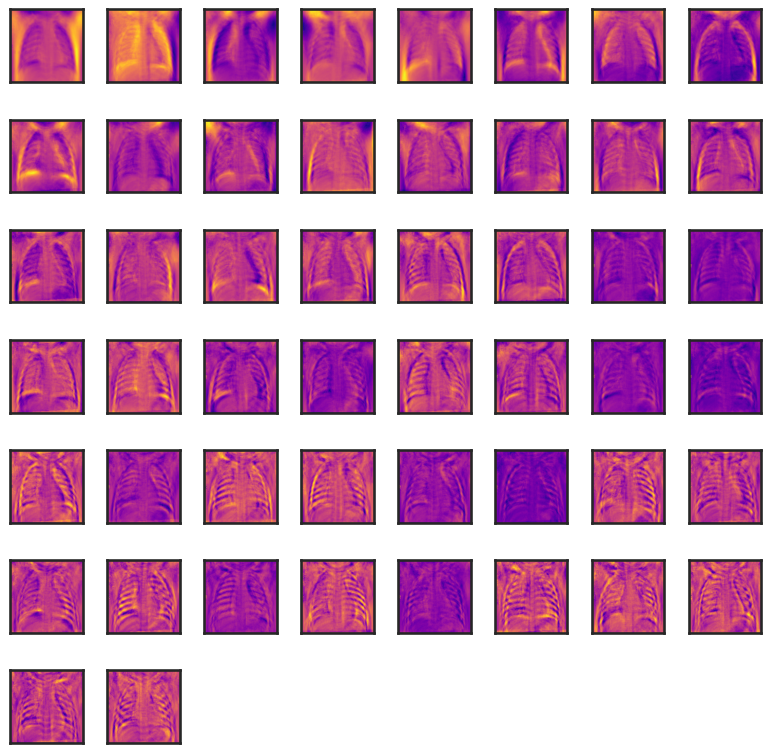

Number of principal components:  50


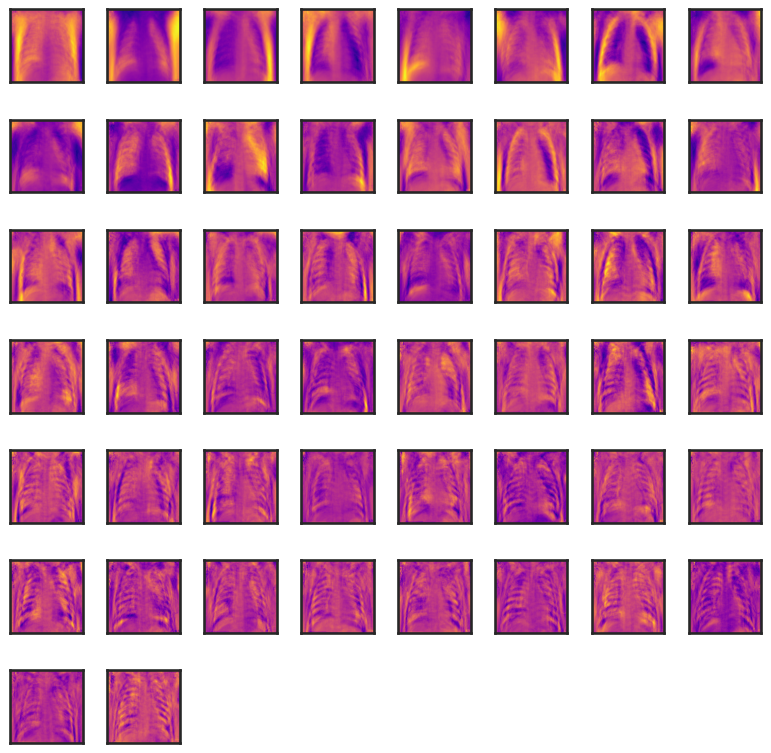

In [ ]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, n_comp=50):
    """"
    Applies PCA on the images and returns the PCA object with the main components.
    full_mat: Matrix of images (each image must be a row of the matrix).
    n_comp: number of principal components to calculate.
    """

    pca = PCA(n_components=n_comp, whiten=True)
    pca.fit(full_mat)
    print('Number of principal components: ', pca.n_components_)
    return pca

def plot_pca(pca, original_shape):
    """
    Plots the eigenimages (principal components) in a grid.
    pca: PCA object with the principal components.
    original_shape: The original size of the images (to resize the components).
    """
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**0.5)
    c = ceil(n / r)

    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks=[], yticks=[])

        # Resize main components to the original shape of the images
        comp_img = pca.components_[i].reshape(original_shape)

        # Normalise the image of components
        comp_img = (comp_img - comp_img.min()) / (comp_img.max() - comp_img.min())  # Normalización a [0, 1]

        # Using a dynamic colour map to improve visualisation
        ax.imshow(comp_img, cmap='plasma', vmin=0, vmax=1)  # Usa 'plasma', 'viridis', o 'jet'

    plt.tight_layout()
    plt.show()



image_shape = (150, 150)


normal_images = np.array([img.flatten() / 255.0 for img in training_images['NORMAL']])
pnemonia_images = np.array([img.flatten() / 255.0 for img in training_images['PNEUMONIA']])

# Aplica PCA y visualiza las eigenimágenes para 'NORMAL'
normal_pca = eigenimages(normal_images, n_comp=50)  # Número fijo de componentes
plot_pca(normal_pca, original_shape=image_shape)  # Pasa el tamaño original de la imagen

# Aplica PCA y visualiza las eigenimágenes para 'PNEUMONIA'
pnemonia_pca = eigenimages(pnemonia_images, n_comp=50)  # Número fijo de componentes
plot_pca(pnemonia_pca, original_shape=image_shape)  # Pasa el tamaño original de la imagen

As we know the models are best trained with small values, so we will normalise the pixels to take values between [0,1] instead of [0,255].

In [ ]:
import os
import numpy as np
import cv2

def cargar_datos(root_path, labels, img_size=150):

    x_train, y_train = [], []
    x_val, y_val = [], []
    x_test, y_test = [], []

    conjuntos = ['train', 'test', 'val']

    for conjunto in conjuntos:
        for clase in labels:
            ruta = os.path.join(root_path, conjunto, clase)

            # Verificar si la ruta existe
            if not os.path.exists(ruta):
                print(f"Advertencia: La ruta {ruta} no existe.")
                continue

            archivos = os.listdir(ruta)  # Obtener todos los archivos de la carpeta
            for img_name in archivos:
                try:
                    # Generar la ruta completa de la imagen
                    img_path = os.path.join(ruta, img_name)

                    # Cargar la imagen en escala de grises
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    # Redimensionar la imagen
                    img_resized = cv2.resize(img, (img_size, img_size))

                    # Normalizar los valores de píxeles (de 0-255 a 0-1)
                    img_normalized = img_resized / 255.0

                    # Convertir la imagen y su etiqueta
                    img_array = np.array(img_normalized)
                    label = 0 if clase == 'NORMAL' else 1  # 0 para NORMAL, 1 para PNEUMONIA

                    # Asignar la imagen y la etiqueta al conjunto correspondiente
                    if conjunto == 'train':
                        x_train.append(img_array)
                        y_train.append(label)
                    elif conjunto == 'val':
                        x_val.append(img_array)
                        y_val.append(label)
                    elif conjunto == 'test':
                        x_test.append(img_array)
                        y_test.append(label)

                except Exception as e:
                    print(f'Error al cargar la imagen {img_name}: {e}')


    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test


labels = ['PNEUMONIA', 'NORMAL']


x_train, y_train, x_val, y_val, x_test, y_test = cargar_datos(root_path, labels)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}, y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (5216, 150, 150), y_train: (5216,)
x_val: (16, 150, 150), y_val: (16,)
x_test: (624, 150, 150), y_test: (624,)


# Machine Learning models for pneumonia detection

We train models that we know perform well in terms of accuracy and data fit. Specifically:
- Logistic Regression
- SVM
- Random Forest

In [ ]:
 # Flatten images (only for classic models, not for CNN)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_bal, y_train_bal = smote.fit_resample(x_train_flat, y_train)

print(f"Balanced classes: {np.bincount(y_train_bal)}")

Balanced classes: [3875 3875]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(x_train_bal, y_train_bal)

y_pred_logreg = logreg.predict(x_test_flat)


print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.94      0.34      0.50       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.83      0.66      0.66       624
weighted avg       0.80      0.74      0.70       624



The logistic regression model achieves 74% accuracy, with excellent recall for PNEUMONIA (99%), meaning it detects nearly all positive cases. However, it performs poorly on NORMAL cases, with only 32% recall, suggesting a strong bias toward predicting pneumonia. Precision is high for NORMAL (94%) but low recall drags down its F1-score. Overall, the model is highly sensitive but not well-balanced.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm = SVC(probability=True, kernel='rbf', class_weight='balanced', random_state=42)
svm.fit(x_train_bal, y_train_bal)

y_pred_svm = svm.predict(x_test_flat)
print("SVM Report:\n", classification_report(y_test, y_pred_svm))

SVM Report:
               precision    recall  f1-score   support

           0       0.93      0.44      0.60       234
           1       0.75      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.81      0.78      0.75       624



The SVM model reaches 78% accuracy, with very high recall for PNEUMONIA (98%), successfully identifying nearly all positive cases. However, it shows low recall for NORMAL (44%), indicating many healthy cases are misclassified. Precision for NORMAL is high (93%), but unbalanced recall causes a lower F1-score. Overall, the model is highly sensitive to pneumonia but lacks balance in detecting normal cases.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(x_train_bal, y_train_bal)

y_pred_rf = rf.predict(x_test_flat)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.93      0.52      0.66       234
           1       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.75      0.76       624
weighted avg       0.83      0.80      0.79       624



The Random Forest model achieves 80% accuracy, with strong recall for PNEUMONIA (98%) and improved recall for NORMAL (52%) compared to other models. While it still favors pneumonia, the balance is better. Precision remains high for both classes, and overall, the model is more balanced and effective, offering strong performance on both classes.

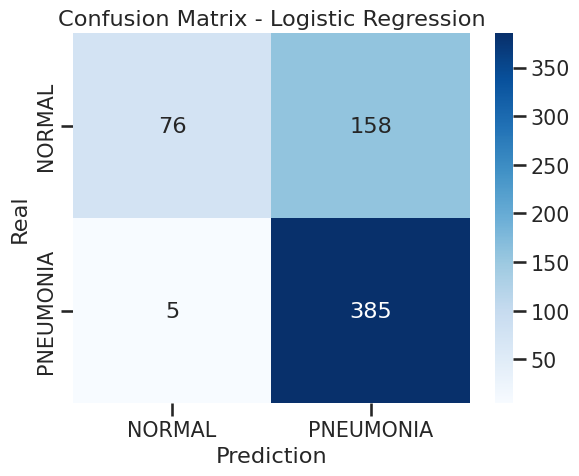

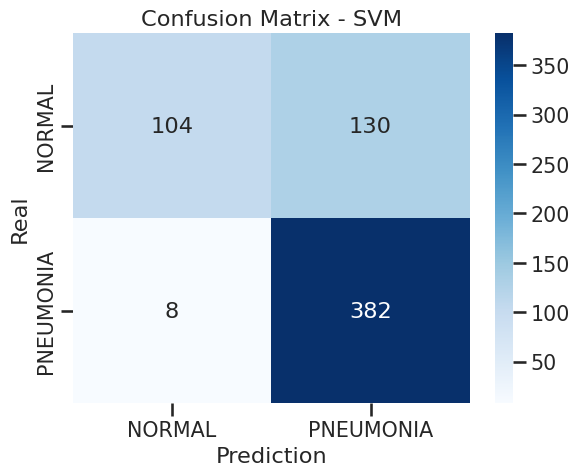

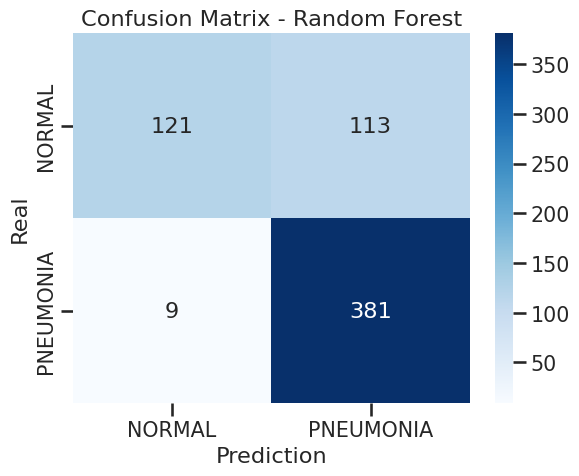

In [ ]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

plot_cm(y_test, y_pred_logreg, "Confusion Matrix - Logistic Regression")
plot_cm(y_test, y_pred_svm, "Confusion Matrix - SVM")
plot_cm(y_test, y_pred_rf, "Confusion Matrix - Random Forest")

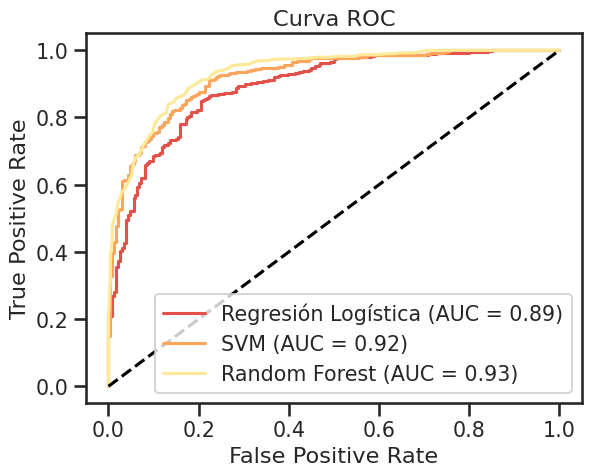

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc(model, x_test, y_test, label):
    y_prob = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure()
plot_roc(logreg, x_test_flat, y_test, 'Logistic Regression')
plot_roc(svm, x_test_flat, y_test, 'SVM')
plot_roc(rf, x_test_flat, y_test, 'Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


The ROC plot shows each model’s trade-off between true positive rate (sensitivity) and false positive rate (1 – specificity) as you vary the classification threshold. The diagonal dashed line is “random guessing” (AUC = 0.50).  

- **Logistic Regression**  achieves an AUC of 0.89, meaning it correctly ranks pneumonia vs. normal about 89% of the time.  
- **SVM** improves on that with AUC = 0.92, rising more steeply toward high sensitivity at low false-positive rates.  
- **Random Forest** performs best (AUC = 0.93), hugging the top‐left corner most closely—so it can detect a high fraction of true cases while keeping false alarms low.  

In short, all three models do well, but Random Forest gives the strongest overall discrimination.  


# Deep Learning models for pneumonia detection
As we mentioned at the beginning, the dataset is quite unbalanced, which means that when training the models we do not get a good accuracy. Consequently, we decided to increase the data sample for the ‘Normal’ catergory and to balance the classes. We did this by implementing the data augmentation technique.

In [ ]:
# resize data for deep learning
img_size= 150

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Crear un generador de datos de imágenes con normalización
datagen = ImageDataGenerator(
        featurewise_center=False,  # Ajustar el centro de las características
        samplewise_center=False,   # Ajustar el centro de las muestras
        featurewise_std_normalization=False,  # Normalización por la desviación estándar de las características
        samplewise_std_normalization=False,  # Normalización por la desviación estándar de las muestras
        zca_whitening=False,  # No usar ZCA whitening
        horizontal_flip=True,  # Realizar volteo horizontal de las imágenes
        vertical_flip=False,  # No realizar volteo vertical
        rotation_range=20,  # Rango de rotación aleatoria
        width_shift_range=0.2,  # Desplazamiento horizontal de las imágenes
        height_shift_range=0.2,  # Desplazamiento vertical de las imágenes
        shear_range=0.2,  # Desplazamiento por cizalladura
        zoom_range=0.2,  # Zoom aleatorio
        fill_mode='nearest')  # Rellenar los píxeles vacíos con el valor más cercano

# Usar el generador con tu conjunto de datos
datagen.fit(x_train)

## CNN for pneumonia detection

We start by applying a CNN with the following characteristics:

1. Input Layer:
Input Shape: (150, 150, 1) - 150x150 pixel grayscale images (1 channel).

2. Convolutional Layers (Conv2D):

- Filters: 32, 64, 64, 64, 128, 256 (Increases as network progresses).
- Filter size: (3, 3).

- Activation: ReLU (common non-linear function for CNNs).

- Padding: ‘same’ (keeps the spatial dimensions of the input).

- Strides: 1 (convolution moves one pixel at a time).


3. Normalisation and Regularisation:

- BatchNormalization: Normalises activations to speed up training and improve stability.

- Dropout: Used in some layers to prevent overfitting (with values of 0.1 and 0.2).

4. Pooling layers (MaxPool2D): MaxPooling: Reduce the spatial dimensions of the images (size (2, 2), strides=2). Used after each convolutional layer to reduce the number of parameters and prevent overfitting.

5. Final Dense Layer:
128-unit dense layer with ReLU: Fully connected layer to capture complex image features. With single unit and sigmoid activation, ideal for binary classification.

6. Model Compilation:
- Optimiser: RMSprop (adaptive and efficient for training CNNs).

- Loss function: binary_crossentropy (suitable for binary classification).

- Metric: accuracy (measures model performance).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(5216, 150, 150, 1)
(16, 150, 150, 1)
(624, 150, 150, 3)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Crear el callback de early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitorea la pérdida en validación
    patience=3,             # Número de epochs sin mejora antes de detener
    restore_best_weights=True # Recupera los mejores pesos
)

# Usar el generador en el entrenamiento
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=[learning_rate_reduction, early_stopping])


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 472s 3s/step - accuracy: 0.9567 - loss: 0.1132 - val_accuracy: 0.8750 - val_loss: 0.4421 - learning_rate: 2.7000e-05
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.9550 - loss: 0.1271 - val_accuracy: 0.6250 - val_loss: 0.6911 - learning_rate: 2.7000e-05
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9619 - loss: 0.1120
Epoch 3: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
163/163 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.9619 - loss: 0.1120 - val_accuracy: 0.6875 - val_loss: 0.5971 - learning_rate: 2.7000e-05
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.9497 - loss: 0.1365 - val_accuracy: 0.7500 - val_loss: 0.4487 - learning_rate: 8.1000e-06


In [ ]:
import tensorflow as tf

x_test_gray = tf.image.rgb_to_grayscale(x_test)
y_test = np.argmax(y_test, axis=1)

loss, accuracy = model.evaluate(x_test_gray, y_test, verbose=0)

print("Loss of the model is ", loss)
print("Accuracy of the model is ", accuracy * 100, "%")

Loss of the model is  0.3538287878036499
Accuracy of the model is  85.89743375778198 %


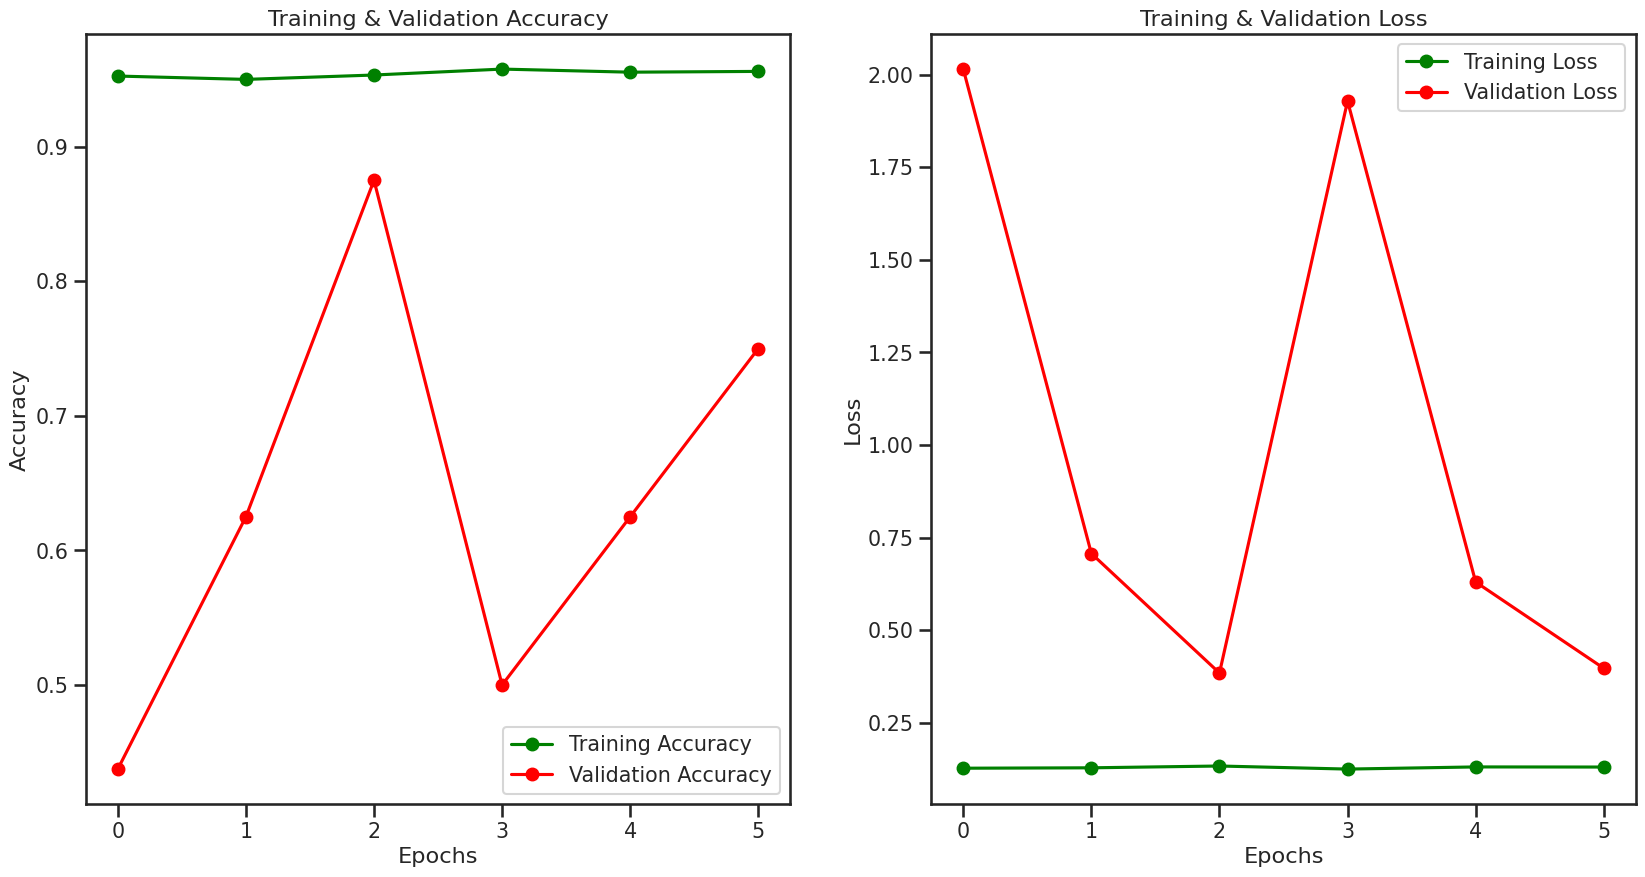

In [ ]:
epochs = range(len(train_acc))  # Esto ajusta el eje x a los datos reales

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

The training history shows the evolution of accuracy and loss for both the training and validation sets across epochs. The use of EarlyStopping indicates that the training was halted early to avoid overfitting, once the validation loss stopped improving over three consecutive epochs.

In the accuracy plot, we observe that while training accuracy continues to increase, validation accuracy peaks early and then begins to decline slightly. This divergence suggests the onset of overfitting, which the early stopping mechanism successfully detected and mitigated.

The loss plot further confirms this behavior: training loss decreases steadily, but validation loss bottoms out and then increases, triggering the early stop. The model's weights were restored to the point with the best validation performance, ensuring that the final model does not suffer from degraded generalization.

Overall, the training process demonstrates good use of early stopping to maintain a balance between model learning and generalization, especially important in deep CNNs prone to overfitting with prolonged training.

In [ ]:
# Realizamos la predicción con las imágenes correctas (escala de grises)
predictions = model.predict(x_test_gray)

# Convertimos probabilidades en clases
predictions = (predictions > 0.5).astype("int32")

# Reestructuramos y mostramos las primeras 15 predicciones
predictions = predictions.reshape(1, -1)[0]
print(predictions[:15])

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 846ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn.metrics import classification_report

# Imprime el reporte de clasificación
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)', 'Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.76      0.92      0.83       234
   Normal (Class 1)       0.95      0.82      0.88       390

           accuracy                           0.86       624
          macro avg       0.85      0.87      0.85       624
       weighted avg       0.87      0.86      0.86       624



The CNN model achieved an accuracy of 86% on the test dataset. For class 0 (Pneumonia), the model got a precision of 0.76 and recall of 0.92, which means it found most pneumonia cases but also made some mistakes. For class 1 (Normal), precision was higher (0.95) and recall was lower (0.82), indicating the model was good at predicting normal images, although it missed some. The F1-scores were 0.83 and 0.88 respectively. This shows the model works pretty well and could be used for pneumonia detection, but more testing is needed.



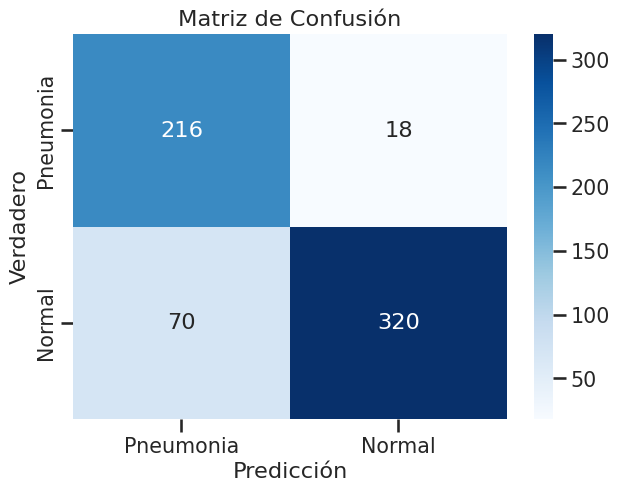

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula la matriz de confusión
cm = confusion_matrix(y_test, predictions)

# Visualiza la matriz de confusión con un mapa de calor
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pneumonia', 'Normal'], yticklabels=['Pneumonia', 'Normal'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()


In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

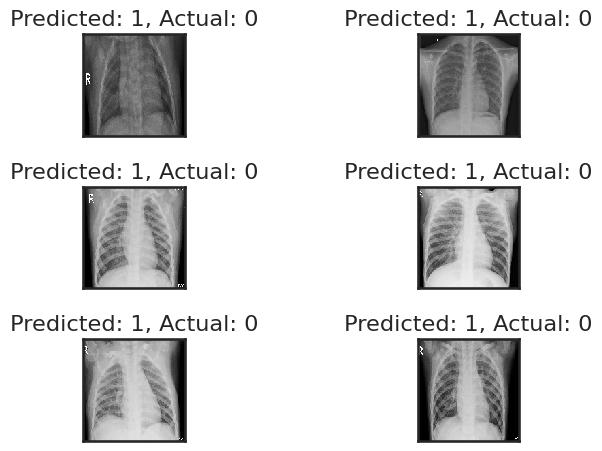

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(tf.squeeze(x_test_gray[c]), cmap="gray", interpolation='none')
    plt.title("Predicted: {}, Actual: {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

# Pre-trained models

For this task, we adopted a transfer learning approach using the VGG16 architecture pretrained on ImageNet. The final classification layers were adapted for binary output, and the model was trained for 3 epochs.

In [ ]:
from tensorflow.keras.applications import VGG16
IMG_HEIGHT=224
IMG_WIDTH=224
vgg16 = VGG16(weights     = 'imagenet',
              include_top = False,
              # Definimos el tamaño de la capa de entrada
              # igual a las dimensiones de las imágenes
              input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential  # Importamos Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout  # Importamos las capas necesarias
from tensorflow.keras.applications import VGG16  # Asegúrate de importar VGG16
from tensorflow.keras import layers

# Asegúrate de tener tus parámetros de imagen definidos
IMG_HEIGHT = 224  # Ejemplo de altura de la imagen
IMG_WIDTH = 224   # Ejemplo de ancho de la imagen

# Cargar VGG16 preentrenado sin la capa superior
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Congelar las primeras capas de VGG16
vgg16.trainable = False

# Crear el modelo secuencial
model_vgg16 = Sequential()

# Añadir la capa de entrada
model_vgg16.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

# Añadir VGG16 como una capa
model_vgg16.add(vgg16)

# Aplanar la salida de VGG16
model_vgg16.add(Flatten())

# Añadir una capa densa con 128 neuronas
model_vgg16.add(Dense(128, activation='relu'))

# Añadir una capa Dropout para evitar overfitting
model_vgg16.add(Dropout(0.4))

# Añadir la capa de salida
model_vgg16.add(Dense(1, activation='sigmoid'))

# Mostrar el resumen del modelo
model_vgg16.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall  # Importamos las métricas necesarias

# Usamos las mismas métricas de evaluación
metrics = [BinaryAccuracy(name='accuracy'),
           AUC(name='roc_auc'),
           Precision(name='precision'),
           Recall(name='recall')]

# Compilamos el modelo
model_vgg16.compile(
    optimizer='adam',  # Asegúrate de usar un optimizador (como 'adam', 'sgd', etc.)
    loss='binary_crossentropy',
    metrics=metrics
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Importamos EarlyStopping y ModelCheckpoint

# Configuración para guardar el modelo durante el entrenamiento
model_filepath = "modelo_vgg16_jrl.h5"  # Ruta donde guardarás el modelo

checkpoint_vgg16 = ModelCheckpoint(model_filepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')  # Guardará el modelo con el menor valor de val_loss

# Configuración para early stopping (detener el entrenamiento si no mejora)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=1,  # Número de épocas sin mejora antes de detener el entrenamiento
                           restore_best_weights=True)  # Restaura los mejores pesos encontrados

# Lista de Callbacks
callbacks_list_vgg16 = [checkpoint_vgg16, early_stop]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Definir parámetros
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 3

# Crear el generador para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizamos las imágenes
    rotation_range=40,  # Rango de rotación aleatoria
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2,  # Desplazamiento vertical
    shear_range=0.2,  # Distorsión de la imagen
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest'  # Estrategia para rellenar los píxeles vacíos
)

# Crear el generador para la validación (normalmente solo aplicamos rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Crear los generadores para las imágenes de entrenamiento y validación
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Usamos 'binary' ya que tienes 2 clases
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Definir el modelo VGG16 preentrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Congelar las capas del modelo base para que no se entrenen durante el primer entrenamiento
base_model.trainable = False

# Crear el modelo completo
model_vgg16 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Compilar el modelo
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Definir el callback para guardar el modelo durante el entrenamiento
checkpoint = ModelCheckpoint(
    'modelo_vgg16.h5',  # Nombre del archivo donde se guardará el modelo
    monitor='val_loss',  # Métrica a seguir (en este caso se sigue la pérdida de validación)
    save_best_only=True,  # Guardar solo el modelo si mejora la métrica
    save_weights_only=False,  # Guardar el modelo completo (no solo los pesos)
    mode='min',  # Guardar el modelo cuando la métrica 'val_loss' haya mejorado (menor)
    verbose=1  # Mostrar información sobre el guardado
)

# Entrenar el modelo y guardar el mejor modelo
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]  # Añadir el callback de ModelCheckpoint
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8222 - loss: 0.4882 
Epoch 1: val_loss improved from inf to 0.47950, saving model to modelo_vgg16.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 3699s 23s/step - accuracy: 0.8226 - loss: 0.4869 - val_accuracy: 0.7500 - val_loss: 0.4795
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9125 - loss: 0.2049 
Epoch 2: val_loss did not improve from 0.47950
163/163 ━━━━━━━━━━━━━━━━━━━━ 3663s 22s/step - accuracy: 0.9126 - loss: 0.2048 - val_accuracy: 0.6875 - val_loss: 0.8130
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9302 - loss: 0.1582 
Epoch 3: val_loss improved from 0.47950 to 0.46697, saving model to modelo_vgg16.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 3617s 22s/step - accuracy: 0.9302 - loss: 0.1582 - val_accuracy: 0.7500 - val_loss: 0.4670


In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
model_vgg16.save('my_model.keras')

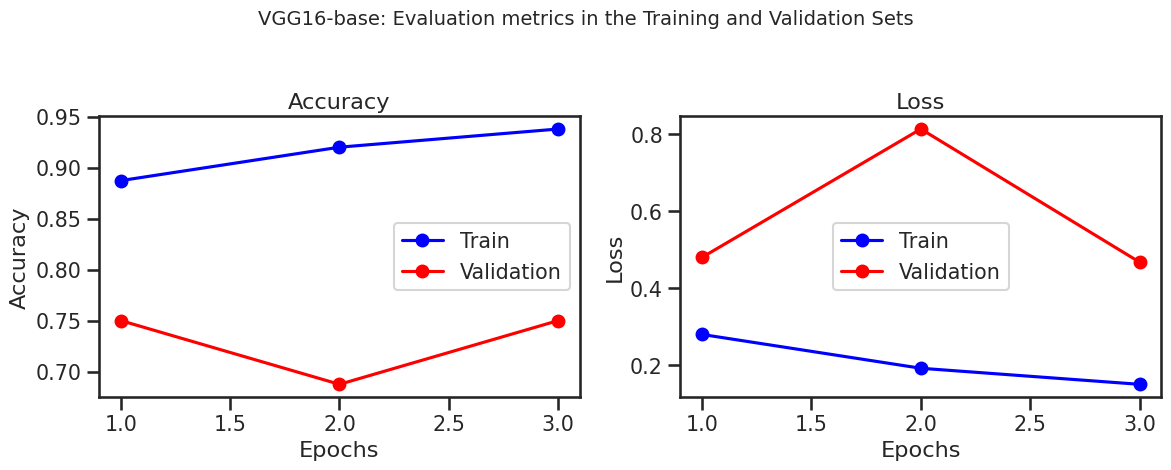

In [ ]:
def plot_history(history, suptitle=''):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(suptitle, fontsize=14)

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train')
    plt.plot(epochs, val_acc, 'ro-', label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train')
    plt.plot(epochs, val_loss, 'ro-', label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

train_hist_v16 = history_vgg16
plot_history(train_hist_v16,
             suptitle='VGG16-base: Evaluation metrics in the Training and Validation Sets')

The plots illustrate the training and validation accuracy and loss for the VGG16-base model over 3 epochs.

In terms of accuracy, the model demonstrates consistently high performance on the training set (above 90%), while validation accuracy remains slightly lower but stable across epochs. This indicates that the model is learning effectively and generalizing relatively well to unseen data without dramatic drops in validation accuracy.

For the loss, the training loss decreases steadily, suggesting the model is optimizing its performance on the training data. The validation loss shows a peak at epoch 2, followed by a noticeable drop in epoch 3, which may indicate that the model is starting to generalize better after a temporary overfitting trend. The gap between training and validation loss is moderate, which is a positive sign, though it may warrant monitoring in further training.

Overall, the metrics suggest that the model is performing well with limited training and is not significantly overfitting. Additional epochs might improve performance, but care should be taken to avoid overfitting, especially given the signs of potential divergence seen in the second epoch.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generador para datos de prueba (sin aumentos)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Reemplaza esto con la ruta real
    target_size=(150, 150),     # O el tamaño de entrada de tu modelo VGG16
    batch_size=32,
    class_mode='categorical',   # o 'binary' si es clasificación binaria
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [ ]:
x_test, y_test = next(test_generator)
print("X shape:", x_test.shape)
print("Y shape:", y_test.shape)


X shape: (32, 150, 150, 3)
Y shape: (32, 2)


In [ ]:
import numpy as np

# Reiniciar el generador por si se ha usado previamente
test_generator.reset()

# Inicializar listas
x_test = []
y_test = []

# Recolectar todos los batches
for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    x_test.append(x_batch)
    y_test.append(y_batch)

# Convertir a arrays planos
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Asegurar 3 canales para VGG16 (que espera RGB)
if x_test.shape[-1] == 1:
    x_test = np.repeat(x_test, 3, axis=-1)

# Confirmar shapes
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test sample: {y_test[:5]}")

x_test shape: (624, 150, 150, 3)
y_test shape: (624, 2)
y_test sample: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # <-- Importante
    batch_size=32,
    class_mode='binary',     # o 'categorical', según tu modelo
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [ ]:
# Reiniciar y recolectar datos
test_generator.reset()
x_test = []
y_test = []

for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    x_test.append(x_batch)
    y_test.append(y_batch)

x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Convertir etiquetas one-hot a clases si es necesario
if y_test.shape[-1] == 2:
    y_test = np.argmax(y_test, axis=1)

# Evaluar
score_test_vgg16 = model_vgg16.evaluate(x_test, y_test, verbose=1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 417s 21s/step - accuracy: 0.8339 - loss: 0.4633


In [ ]:
# Etiquetas reales
y_test = test_generator.classes
# Predicciones
test_generator.reset()

# Predecir
y_pred_v16 = model_vgg16.predict(test_generator)

# Convertir a clases binarias
y_pred_classes_v16 = (y_pred_v16 >= 0.5).astype('int32')

# Etiquetas verdaderas
y_test = test_generator.classes


20/20 ━━━━━━━━━━━━━━━━━━━━ 423s 21s/step


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cfn_matrix(y_true, y_pred, suptitle='Matriz de Confusión'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(suptitle)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()


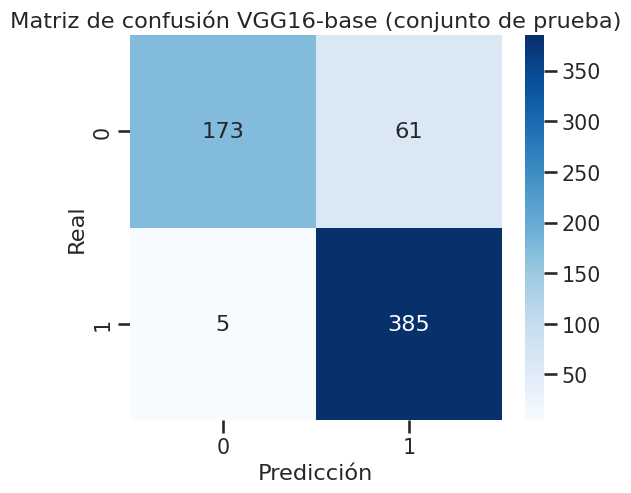

In [ ]:
# Genera la gráfica
plot_cfn_matrix(y_test, y_pred_classes_v16,
    suptitle='Matriz de confusión VGG16-base (conjunto de prueba)')

To better understand the model’s performance, we evaluated it on a hold-out test set and generated a confusion matrix (Figure 2). The confusion matrix indicates that out of the total test samples, 173 pneumonia cases were correctly classified, while 61 were misclassified as normal. Conversely, only 5 normal cases were misclassified as pneumonia, and 385 were correctly identified. These results suggest a tendency of the model to favor the "normal" class, as reflected by a higher number of false negatives (pneumonia predicted as normal), which is clinically concerning.

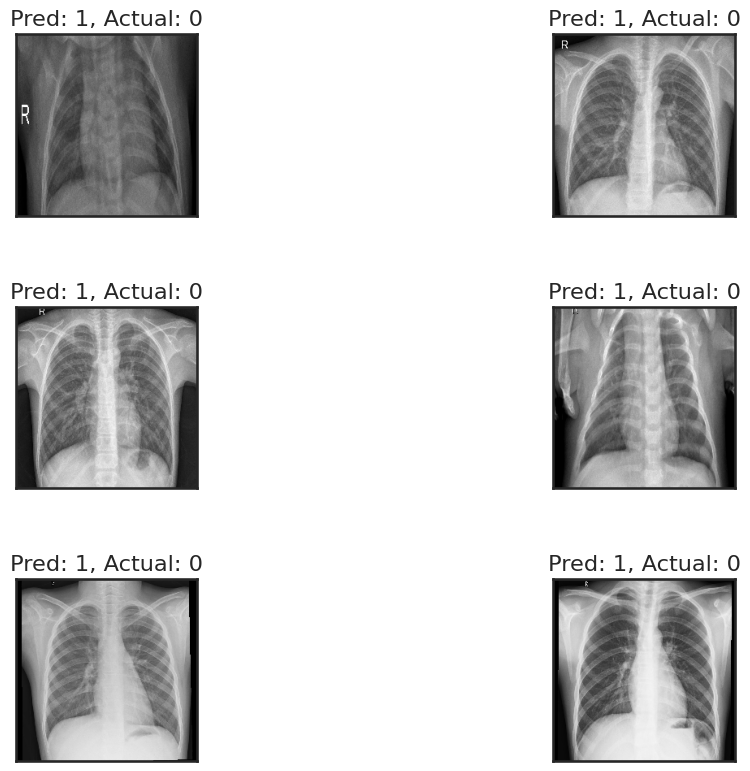

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Asegura que y_test y predicciones estén aplanadas
y_true = y_test.flatten()
y_pred = y_pred_classes_v16.flatten()

# Encuentra los índices incorrectos
incorrect = np.where(y_pred != y_true)[0]

# Visualiza los primeros errores
plt.figure(figsize=(10, 8))
for i, idx in enumerate(incorrect[:6]):
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[idx])  # RGB image (ya tiene 3 canales)
    plt.title(f"Pred: {y_pred[idx]}, Actual: {y_true[idx]}")
    plt.tight_layout()

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


**GENERATIVE**

**Autoencoder for reconstruction and anomaly detection**

1. Train an autoencoder with ‘normal’ images only.

2. Then use it to reconstruct new images (both normal and pneumonia).

3. Calculate the reconstruction error: images with pneumonia should have higher error → anomaly detection.



In [ ]:
# Verificar la forma de los arrays
print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}, y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (5216, 150, 150), y_train: (5216,)
x_val: (16, 150, 150), y_val: (16,)
x_test: (624, 150, 150), y_test: (624,)


In [ ]:
# Expand to 4D for Keras: (N, 150, 150, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
x_train_normal = x_train[y_train == 0]
x_val_normal = x_val[y_val == 0]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     BatchNormalization, Dropout, Cropping2D)

input_img = Input(shape=(150, 150, 1))

# Codificador
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decodificador
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Cropping2D(((1, 1), (1, 1)))(x)  # Ajusta de 152x152 a 150x150
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 38, 38, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 38, 38, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 38, 38, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 76, 76, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 76, 76, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 76, 76, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 152, 152, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 150, 150, 64)   │             

 Total params: 50,657 (197.88 KB)

 Trainable params: 50,209 (196.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,                # espera 5 épocas sin mejora
    restore_best_weights=True # restaura la mejor versión del modelo
)

history = autoencoder.fit(
    x_train_normal, x_train_normal,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val_normal, x_val_normal),
    callbacks=[early_stop]
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 326s 8s/step - loss: 0.6648 - val_loss: 0.6850
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - loss: 0.5675 - val_loss: 0.6826
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 300s 7s/step - loss: 0.5640 - val_loss: 0.6782
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 312s 7s/step - loss: 0.5621 - val_loss: 0.6744
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 333s 7s/step - loss: 0.5616 - val_loss: 0.6711
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 291s 7s/step - loss: 0.5591 - val_loss: 0.6656
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 335s 7s/step - loss: 0.5601 - val_loss: 0.6622
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 312s 7s/step - loss: 0.5599 - val_loss: 0.6572
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - loss: 0.5595 - val_loss: 0.6465
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 324s 7s/step - loss: 0.5579 - val_loss: 0.6306
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 335s 7s/step - loss: 0.5584 - val_loss: 0.6152
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 309s 7s/step - loss: 0.5

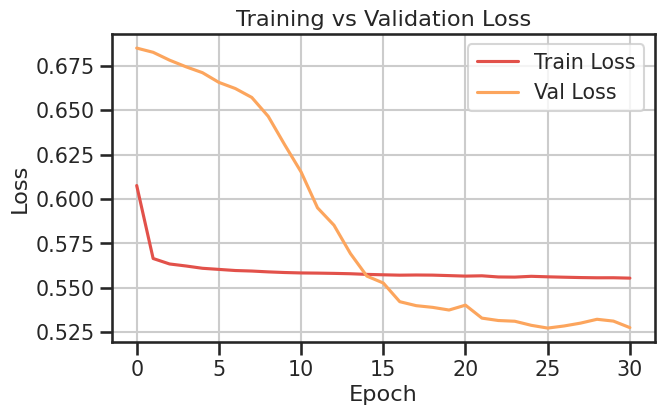

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'],     label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.title('Training vs Validation Loss')
plt.show()

The training loss decreases rapidly over the first 5–10 epochs (from about 0.60 down to 0.55) and then plateaus around 0.55, indicating minimal further improvement. In parallel, the validation loss starts higher (around 0.68), drops sharply to approximately 0.53 by epoch 20, and then remains flat. This behavior suggests the autoencoder converges properly without overfitting, as the validation loss does not rebound after its minimum

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report

reconstructed = autoencoder.predict(x_test)
errors = np.mean((x_test - reconstructed)**2, axis=(1,2,3))

# Ajusta umbral óptimo por ROC
fpr, tpr, thr = roc_curve(y_test, errors)
best_idx  = np.argmax(tpr - fpr)
best_thr  = thr[best_idx]
roc_auc   = auc(fpr, tpr)

print(f"Best threshold: {best_thr:.5f}, AUC = {roc_auc:.3f}")

y_pred = (errors > best_thr).astype(int)
print(classification_report(y_test, y_pred, target_names=["Normal","Pneumonia"]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Best threshold: 0.00540, AUC = 0.268
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.67      0.01      0.01       390

    accuracy                           0.38       624
   macro avg       0.52      0.50      0.28       624
weighted avg       0.56      0.38      0.21       624



These results indicate that simply thresholding reconstruction error with the current autoencoder setup fails to effectively distinguish pneumonia from normal cases—tweaking the threshold alone does not improve performance

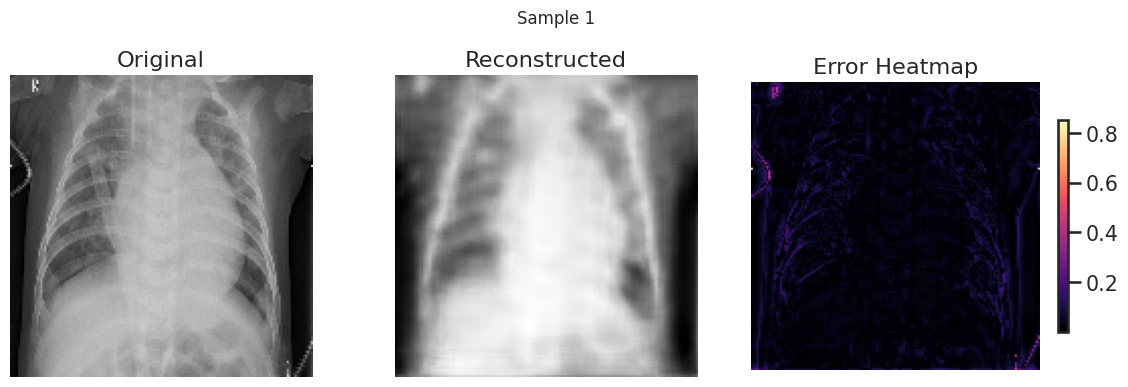

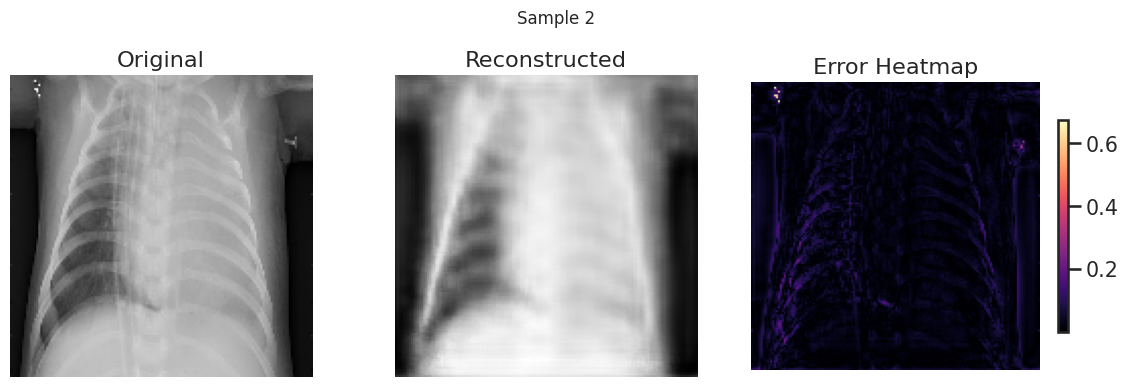

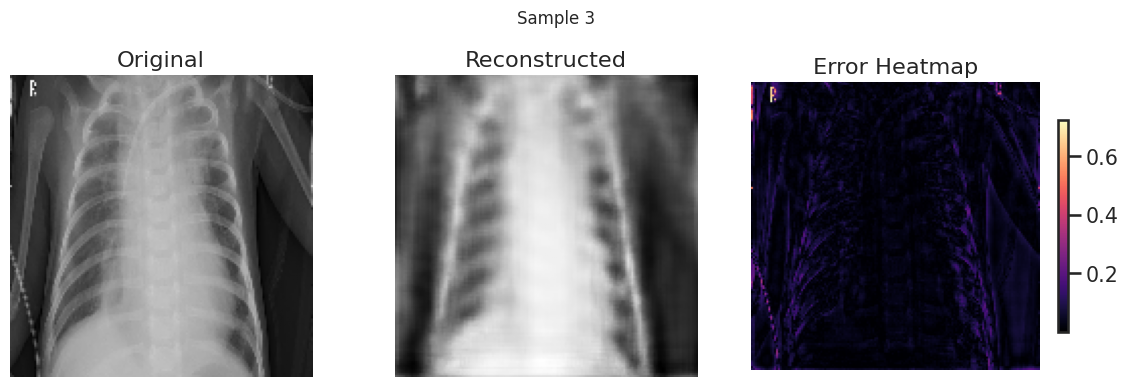

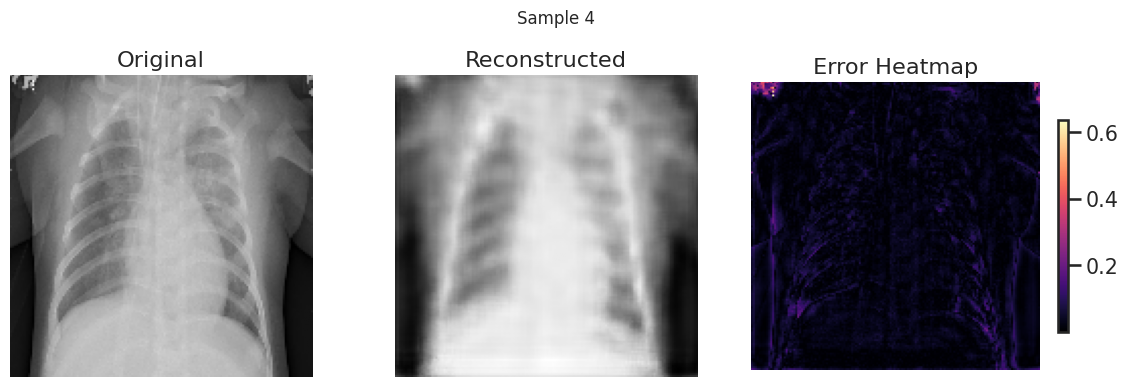

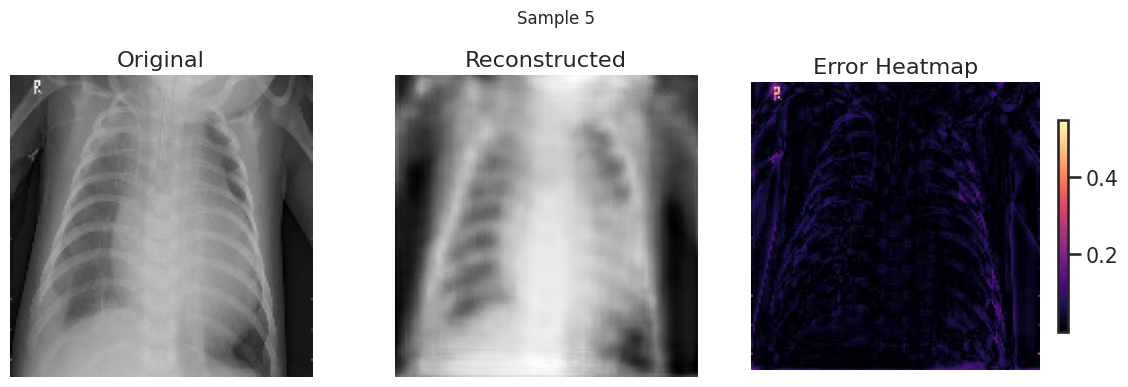

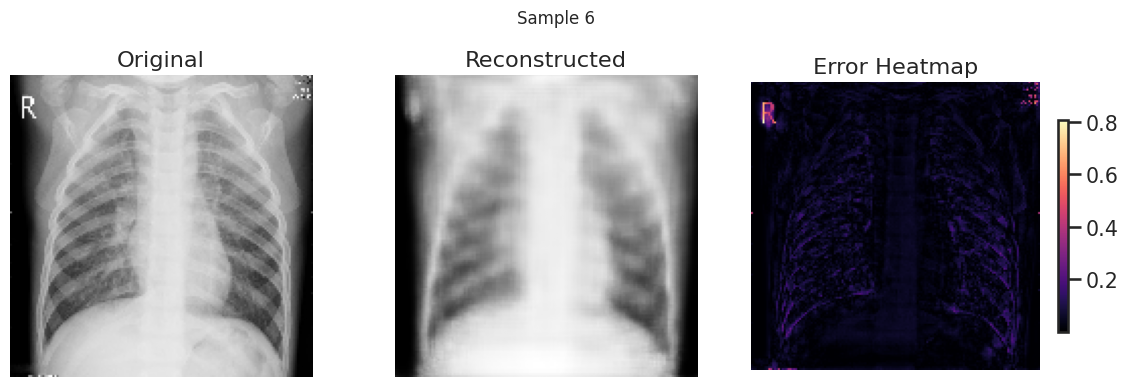

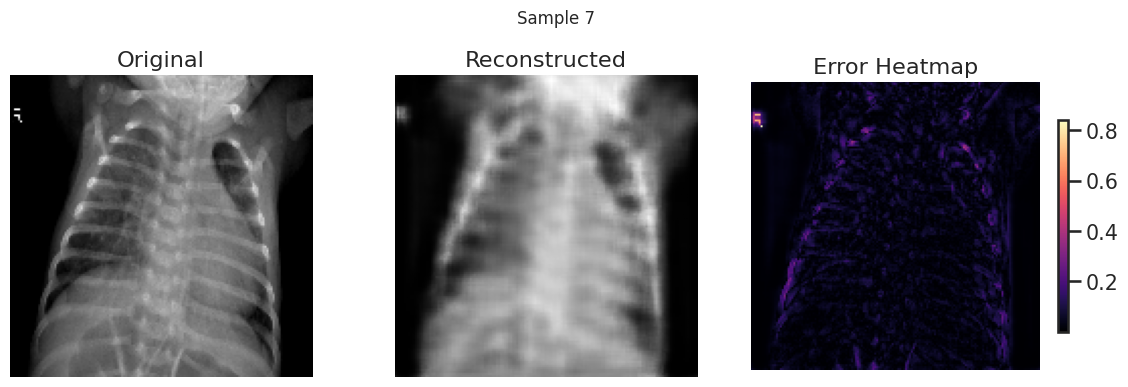

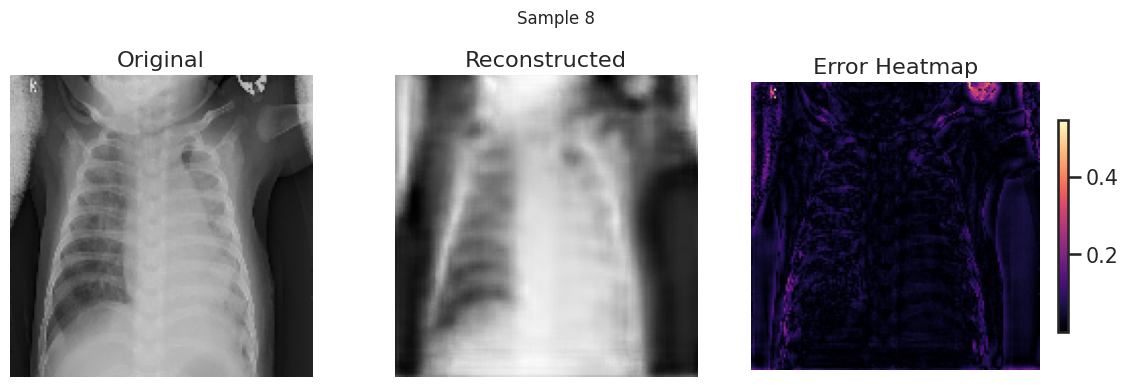

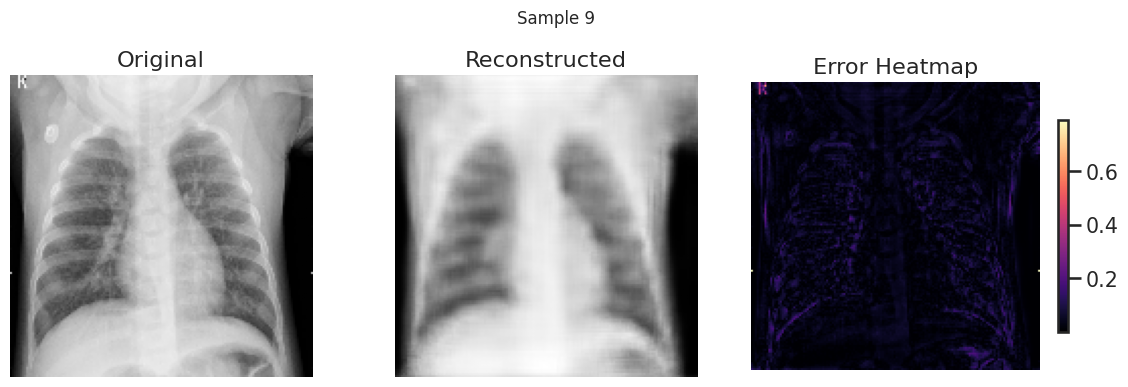

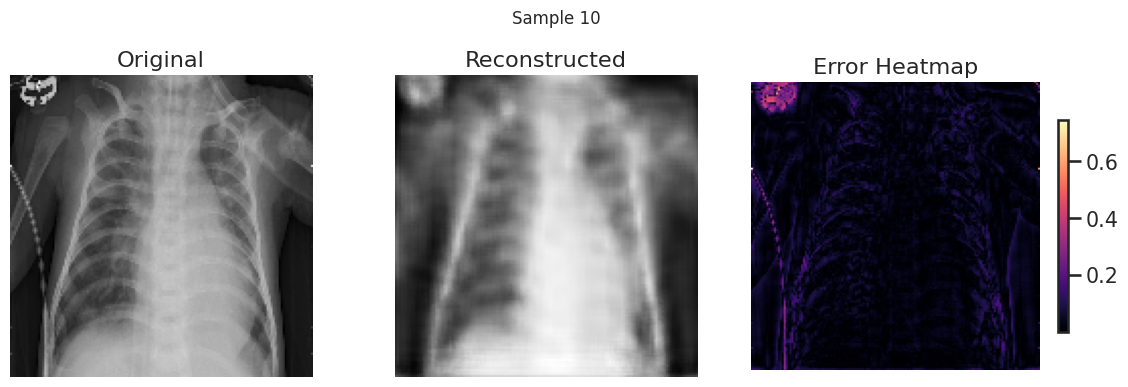

In [ ]:
n =10
for i in range(n):
    err_map = np.abs(x_test[i].squeeze() - reconstructed[i].squeeze())
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x_test[i].squeeze(), cmap='gray');         ax[0].set_title("Original"); ax[0].axis('off')
    ax[1].imshow(reconstructed[i].squeeze(), cmap='gray');  ax[1].set_title("Reconstructed"); ax[1].axis('off')
    im = ax[2].imshow(err_map, cmap='magma');               ax[2].set_title("Error Heatmap"); ax[2].axis('off')
    fig.colorbar(im, ax=ax[2], shrink=0.7)
    plt.suptitle(f"Sample {i+1}", fontsize=12)
    plt.tight_layout()
    plt.show()

In these images, you see original pediatric X-rays and how the autoencoder “reconstructs” them. The autoencoder manages to copy the overall shape of the lungs and the central area, but it does so very blur­ry. Fine details, like the edges of the ribs or small spots, get lost. This means the model learns the big shapes well but doesn’t retain the small details that can be important for spotting subtle issues.

  The heatmap displays the absolute difference between the original X-ray and its autoencoder reconstruction for each pixel.  
  - **Dark areas** → low error (model reconstructed these well)  
  - **Bright/rose areas** → high error (model struggled here)

 **Example: Observations in Sample 1**  
  1. **Image borders and artifacts** light up, since the model didn’t learn those edges or detector marks well.  
  2. **Rib outlines and mediastinum** show some error because their shape varies from patient to patient.  
  3. **Central lung fields** remain dark, meaning the autoencoder reproduces those smooth regions more accurately.